In [1]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR as HALOVI
from complementary_models import HALOMASKVAE as HALOVAE
import scanpy as sc
import scvi

import pandas as pd
# torch.autograd.set_detect_anomaly(True)

Global seed set to 0


In [2]:
### test whole data with RNA only 
path = "/mnt/data0/halo/A594/A549_multiome.h5ad"
adata_multi = sc.read_h5ad(path)
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))

In [4]:
adata_mvi.obs

,cell_name,experiment,treatment_time,batch_id,modality,_scvi_batch
sci-RNA-A-071.GCGGAGTCGA_paired,A549,coassay,3.0,1,paired,0
sci-RNA-A-071.TTGCAGCATT_paired,A549,coassay,1.0,1,paired,0
sci-RNA-A-071.GCGGCCAATC_paired,A549,coassay,3.0,1,paired,0
sci-RNA-A-071.CTGAAGAGAC_paired,A549,coassay,1.0,1,paired,0
sci-RNA-A-071.GGCTCGAGAT_paired,A549,coassay,3.0,1,paired,0
...,...,...,...,...,...,...
sci-RNA-E-022.GGCTATTCGA_paired,A549,coassay,3.0,1,paired,0
sci-RNA-E-022.TCTAGTCAAG_paired,A549,coassay,1.0,1,paired,0
sci-RNA-E-022.TTCTCTACTA_paired,A549,coassay,1.0,1,paired,0
sci-RNA-E-022.TCCTCTCCGT_paired,A549,coassay,3.0,1,paired,0


In [3]:
HALOVI.setup_anndata(adata_mvi, batch_key="modality", time_key='treatment_time')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum(),
    n_latent=20,
    n_dependent=10
)

n_genes :6347
fine tune is False
gate decoder initialization n_input 20, n_output 10313,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [10]:
## load pre-trained models
# model = model.load("model_A549_nocausal_20", adata_mvi)
model = model.load("model_A594_causal_20_015", adata_mvi)

# model = model.load("model_A594_causal_20_01", adata_mvi)



INFO     File model_A594_causal_20_015/model.pt already downloaded                           
n_genes :6347
fine tune is False
gate decoder initialization n_input 20, n_output 10313,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [6]:
model.module.set_finetune_params(0)
model.module.set_train_params(expr_train=True, acc_train=True)
model.train(max_epochs=1000, batch_size=800)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1000/1000: 100%|██████████| 1000/1000 [09:00<00:00,  1.85it/s, loss=5.55e+03, v_num=1]


In [7]:
# model.save("model_myeloid_data_nocausal",overwrite=True)
model.save("model_A549_nocausal_20",overwrite=True)

In [5]:
model.module.alpha = 0.15
model.module.beta_2 = 1e7
model.module.beta_3 = 2e8
model.module.beta_1 = 1e7
print(model.module.alpha)

0.15


In [6]:
## finetune without L0
# model.module.alpha = 0.06
model.module.set_finetune_params(2)
model.module.set_train_params(expr_train=True, acc_train=True)
model.plan_kwargs = {"n_epochs_kl_warmup":300}
model.train(max_epochs=2000, batch_size=800)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 2000/2000: 100%|██████████| 2000/2000 [46:01<00:00,  1.38s/it, loss=2.13e+06, v_num=1]


In [7]:
model.save("model_A594_causal_20_015",overwrite=True)

In [11]:
model = model.load("model_A594_causal03", adata_mvi)

INFO     File model_A594_causal03/model.pt already downloaded                                
n_genes :6347
fine tune is False
gate decoder initialization n_input 10, n_output 10313,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [11]:
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()

In [8]:
latent_expr_indep.shape

(3260, 10)

In [12]:
from complementary_models import torch_infer_nonsta_dir

latent_atac_indep_t = torch.tensor(latent_atac_indep).to('cuda')
latent_expr_indep_t = torch.tensor(latent_expr_indep).to('cuda')
times = torch.tensor(times).to('cuda')

# times = np.array(times.detach().cpu())
score3 = []
score4=[]

latent_atac_dep_t = torch.tensor(latent_atac_dep).to('cuda')
latent_expr_dep_t = torch.tensor(latent_expr_dep).to('cuda')

score1 = []
score2=[]
sample_num = 700
iterations = 30

for i in range(iterations):
    index = np.random.choice(latent_acc.shape[0] , sample_num)
    score3.append(torch_infer_nonsta_dir(latent_atac_indep_t[index,:], latent_expr_indep_t[index,:], times[index])[0].detach().cpu())
    score4.append(torch_infer_nonsta_dir(latent_expr_indep_t[index,:], latent_atac_indep_t[index,:], times[index])[0].detach().cpu())
    score1.append(torch_infer_nonsta_dir(latent_atac_dep_t[index,:], latent_expr_dep_t[index,:], times[index])[0].detach().cpu())
    score2.append(torch_infer_nonsta_dir(latent_expr_dep_t[index,:], latent_atac_dep_t[index,:], times[index])[0].detach().cpu())


score3 = np.array(score3)
score4 = np.array(score4)
print("score3: {}".format(score3))
print("score4: {}".format(score4))
print("score3 :{}, score4: {}, Delta :{}".format(np.mean(score3), np.mean(score4), np.mean(score3) - np.mean(score4)))

score1 = np.array(score1)
score2 = np.array(score2)

print("score1: {}".format(score1))
print("score2: {}".format(score2))
print("score1 :{}, score2: {}, Delta :{}".format(np.mean(score1), np.mean(score2), np.mean(score1) - np.mean(score2)))



score3: [0.07692161 0.07917822 0.07933751 0.0808827  0.07858702 0.0807902
 0.08036499 0.08050308 0.08003895 0.08128788 0.0802008  0.07894845
 0.07931106 0.07832955 0.07965843 0.0800425  0.0768469  0.08042417
 0.0832854  0.0793824  0.08010395 0.07915125 0.08052405 0.07774774
 0.07844605 0.08188273 0.07964929 0.07637755 0.07852119 0.07870408]
score4: [0.0769213  0.07917818 0.07933775 0.08088252 0.07858706 0.08079017
 0.08036503 0.08050316 0.08003903 0.08128801 0.0802008  0.07894866
 0.07931117 0.07832965 0.07965849 0.08004215 0.07684669 0.08042452
 0.08328522 0.07938248 0.08010394 0.07915112 0.08052408 0.07774749
 0.07844603 0.08188262 0.07964917 0.07637735 0.07852108 0.0787042 ]
score3 :0.07951432399613441, score4: 0.0795143044260787, Delta :1.9570055714845935e-08
score1: [0.07692097 0.07917843 0.07933808 0.08088286 0.07858693 0.08079016
 0.08036514 0.08050309 0.08003907 0.08128772 0.0802007  0.07894849
 0.079311   0.07832975 0.07965848 0.08004237 0.07684671 0.08042404
 0.08328523 0.079

## nocausal results

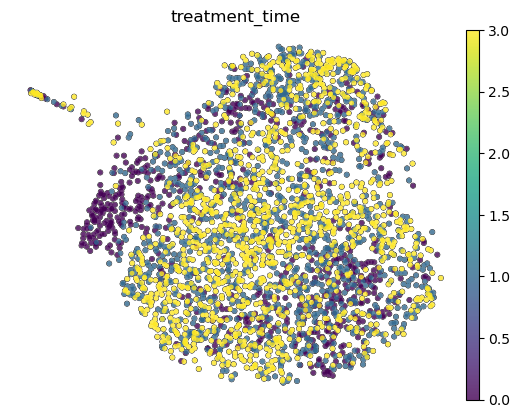

In [10]:

adata_mvi.obsm["latent"] = latent_expr
# sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
sc.pp.neighbors(adata_mvi, use_rep = 'latent')

sc.tl.umap(adata_mvi, min_dist=0.1)

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=['treatment_time'])

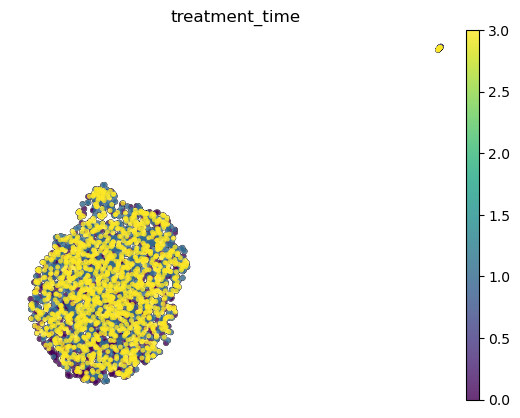

In [11]:
adata_mvi.obsm["latent"] = latent_acc
# sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
sc.pp.neighbors(adata_mvi, use_rep = 'latent')

sc.tl.umap(adata_mvi, min_dist=0.1)

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=["treatment_time"])

## Causal representations


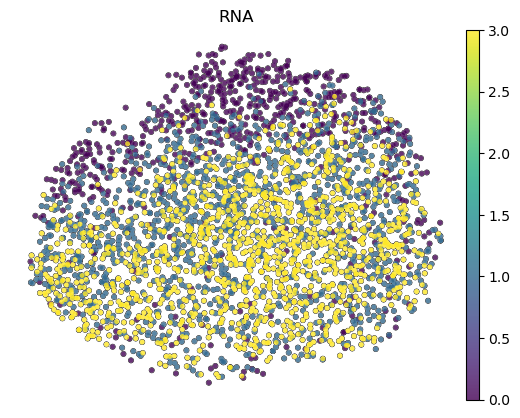

In [13]:
import seaborn as sns
adata_mvi.obsm["latent"] = latent_expr
# sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
sc.pp.neighbors(adata_mvi, use_rep = 'latent')

sc.tl.umap(adata_mvi, min_dist=0.2)

# sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
#           outline_width=(0.1,0), color=["treatment_time"], title="RNA",  cmap=sns.blend_palette(["lightgray", sns.xkcd_rgb["blood"]], as_cmap=True))


sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=["treatment_time"], title="RNA")

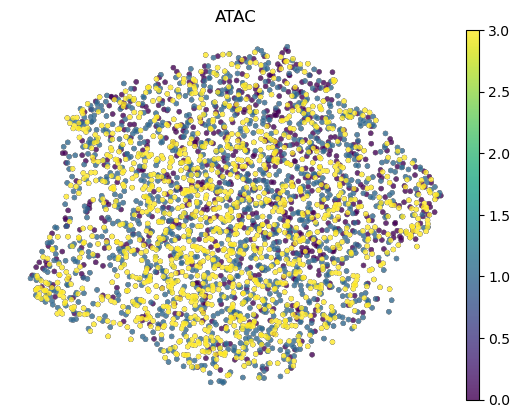

In [14]:
adata_mvi.obsm["latent"] = latent_acc
sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15)
sc.tl.umap(adata_mvi, min_dist=0.1)

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
          outline_width=(0.05,0), color=["treatment_time"], title="ATAC")

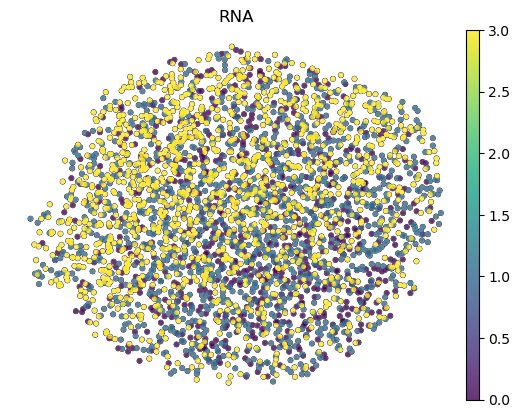

In [15]:
adata_mvi.obsm["latent"] =latent_expr_dep
sc.pp.neighbors(adata_mvi, use_rep="latent")



sc.tl.umap(adata_mvi,min_dist =0.5)
%matplotlib inline
# sc.pl.umap(adata_mvi,color=["treatment_time"], s=50, alpha = 0.8, frameon=False, ncols=2, vmax='p99', title="RNA coupled",  cmap=sns.blend_palette(["lightgray", sns.xkcd_rgb["blood"]],as_cmap=True))

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=["treatment_time"], title="RNA")

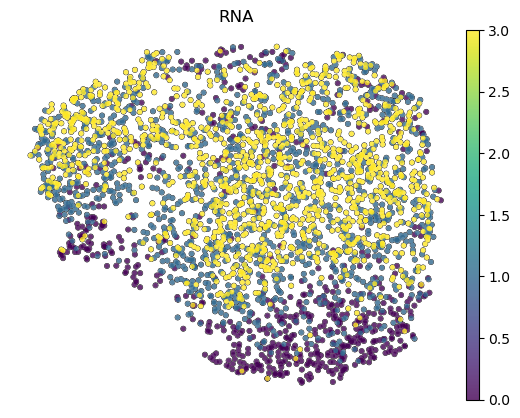

In [16]:
adata_mvi.obsm["latent"] =latent_expr_indep
sc.pp.neighbors(adata_mvi, use_rep="latent")
sc.tl.umap(adata_mvi,min_dist =0.1)

%matplotlib inline
# 
sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=["treatment_time"], title="RNA")


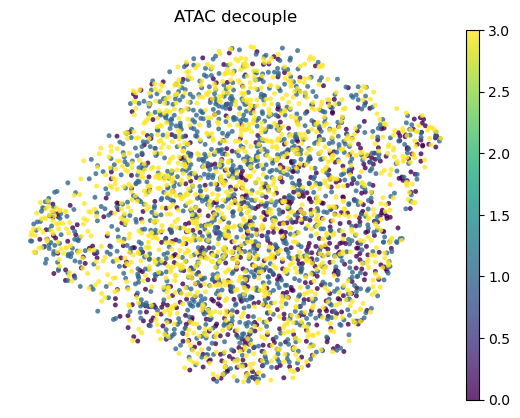

In [17]:
adata_mvi.obsm["latent"] =latent_atac_indep
sc.pp.neighbors(adata_mvi, use_rep="latent")

sc.tl.umap(adata_mvi,min_dist =0.3)

sc.pl.umap(adata_mvi,color=["treatment_time"], s=50, frameon=False, ncols=2, vmax='p99', title="ATAC decouple", alpha = 0.8)


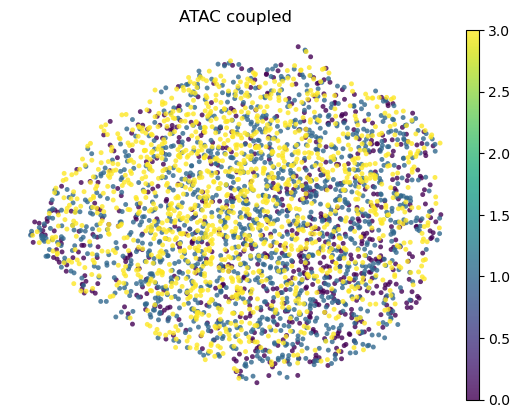

In [18]:
adata_mvi.obsm["latent"] =latent_atac_dep
sc.pp.neighbors(adata_mvi, use_rep="latent")

sc.tl.umap(adata_mvi,min_dist =0.3)

sc.pl.umap(adata_mvi,color=["treatment_time"], s=50, frameon=False, ncols=2, vmax='p99', title="ATAC coupled", alpha = 0.8)

